# Import packages

First, we import the necessary packages for exploring the data.

In [8]:
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import numpy as np
import cartopy.feature as cfeature

# Load in the dataset(s)

This functions preprocesses thet loaded datasets:
- It selects the period of interest.
- It changes the units of precipitation and temperature.

In [9]:
def preprocess_dataset(ds, tstart, tstop):
    ds = ds.sel(time=slice(tstart, tstop))
    tas_vars = ["tas", "tasmax", "tasmin"]
    for tas_var in tas_vars:
        if tas_var in ds:
            ds[tas_var].values = ds[tas_var].values - 273.15
            ds[tas_var].attrs["units"] = "°C"
    
    return ds

In [10]:
run_name = "baseline"
run_info_list = [("2019070100", 720),
                 ("2019071600", 360), 
                 ("2019071612", 348), 
                 ("2019071700", 336), 
                 ("2019071712", 324),
                 ("2019071800", 312), 
                 ("2019071812", 300), 
                 ("2019071900", 288), 
                 ("2019071912", 276), 
                 ("2019072000", 264)]
tstart = "2019-07-22T01"
tstop = "2019-07-28T00"

In [11]:
ds_list = list()

for run_info in run_info_list:
    rstart, nhours = run_info
    filepath = f"../data/{run_name}_{rstart}_{nhours}*.nc"
    ds = xr.open_mfdataset(filepath, engine="netcdf4", chunks="auto").assign_coords(rstart=rstart)
    ds = preprocess_dataset(ds, tstart, tstop)
    ds_list.append(ds)

ds = xr.concat(ds_list, dim="rstart")
ds.load()

<xarray.Dataset>
Dimensions:    (time: 144, lon: 75, lat: 70, bnds: 2, rstart: 10)
Coordinates:
  * time       (time) datetime64[ns] 2019-07-22T01:00:00 ... 2019-07-28
  * lon        (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat        (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds  (time, bnds) datetime64[ns] 2019-07-22T01:00:00 ... 2019-07-28
  * rstart     (rstart) <U10 '2019070100' '2019071600' ... '2019072000'
Dimensions without coordinates: bnds
Data variables:
    pr         (rstart, time, lat, lon) float32 0.0 0.0 ... 9.831e-08 1.233e-07
    tas        (rstart, time, lat, lon) float32 13.9 14.52 14.68 ... 18.36 18.26
    tasmax     (rstart, time, lat, lon) float32 nan nan nan ... 25.22 25.11
    tasmin     (rstart, time, lat, lon) float32 nan nan nan ... 18.36 18.26
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-10-25T11:53:20Z
    frequency:                 1hr
    StartTime:                 2019-07-01T00:00
    EndTime:                   2019-07-31T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

# Maxmimum temperature during period

During the period, what is the maximum temperature in each point?

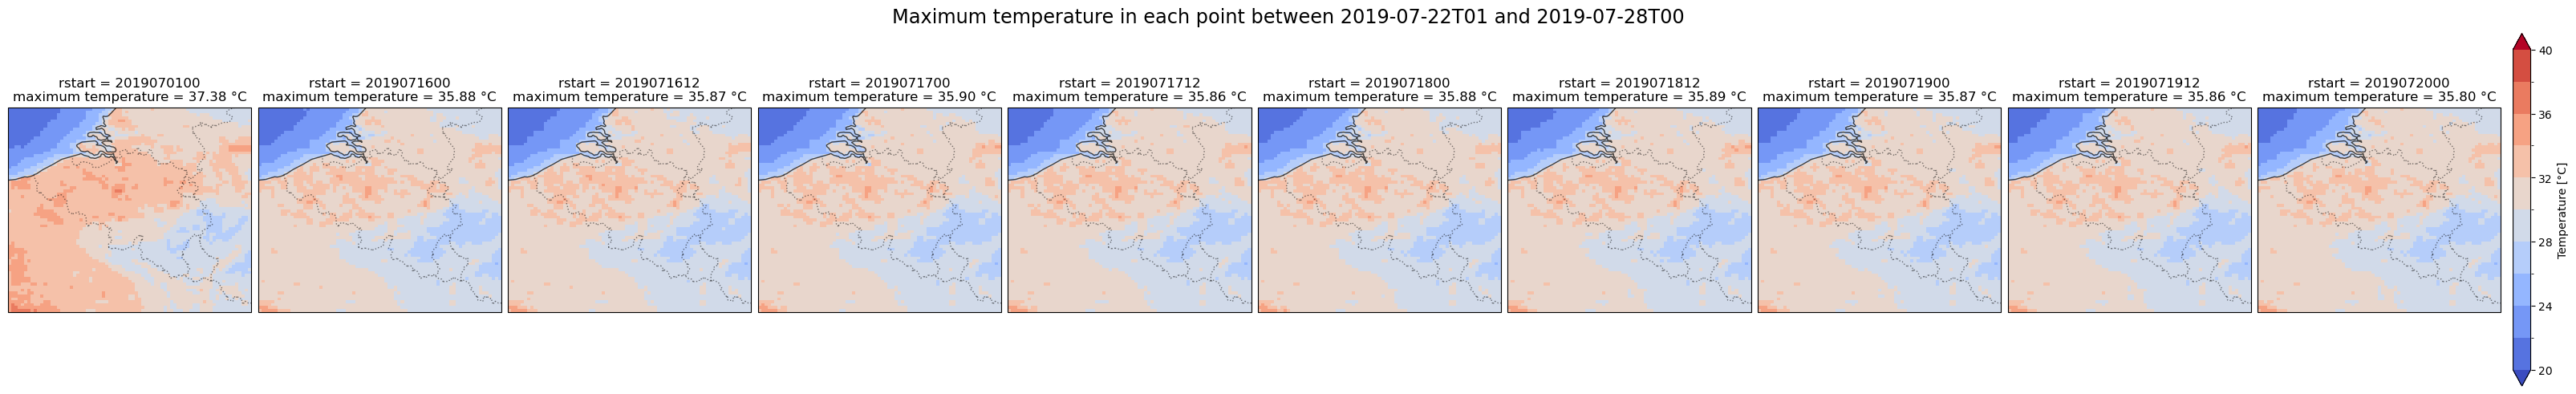

In [12]:
ncols = len(run_info_list)
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols * 3.2, 4.8), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

for idx in range(len(run_info_list)):
    rstart, _ = run_info_list[idx]
    ax = axs[idx]
    p = ds.sel(rstart=rstart).tasmax.max(dim=["time"]).plot(ax=ax, cmap="coolwarm", levels=np.arange(20, 41, 2), extend="both", add_colorbar=False)
    ax.set_title(f"rstart = {rstart}\nmaximum temperature = {ds.sel(rstart=rstart).tasmax.max().values:.2f} °C")
    ax.coastlines(alpha=0.7)
    ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
    ax.set_aspect(1.4)

fig.suptitle(f"Maximum temperature in each point between {tstart} and {tstop}", fontsize="xx-large")
fig.colorbar(p, label="Temperature [°C]")
plt.show()

There are small differences between tasmax.max() and tas.max(). Because of regridding?

# Average maximum temperature

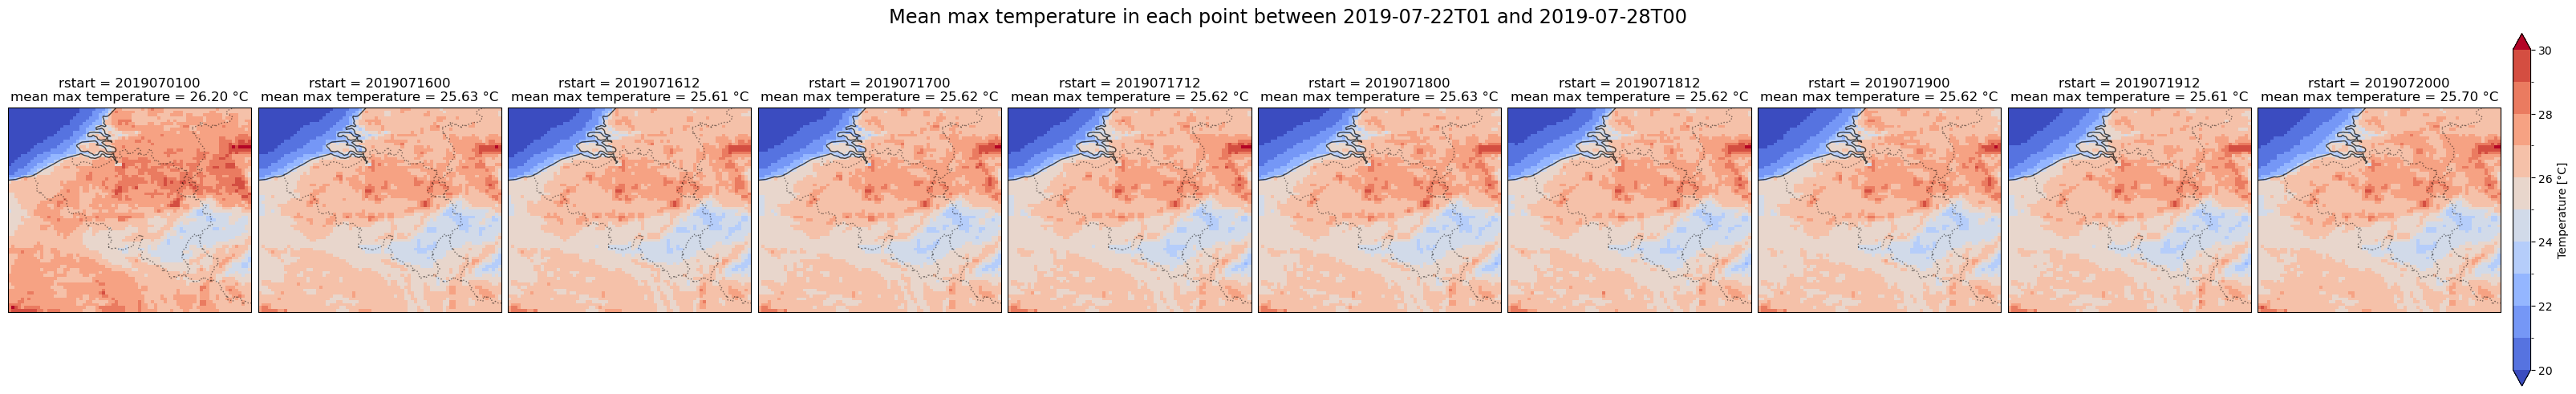

In [6]:
ncols = len(run_info_list)
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols * 3.2, 4.8), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

for idx in range(len(run_info_list)):
    rstart, _ = run_info_list[idx]
    ax = axs[idx]
    p = ds.sel(rstart=rstart).tasmax.mean(dim=["time"]).plot(ax=ax, cmap="coolwarm", levels=np.arange(20, 31, 1), extend="both", add_colorbar=False)
    ax.set_title(f"rstart = {rstart}\nmean max temperature = {ds.sel(rstart=rstart).tasmax.mean().values:.2f} °C")
    ax.coastlines(alpha=0.7)
    ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
    ax.set_aspect(1.4)

fig.suptitle(f"Mean max temperature in each point between {tstart} and {tstop}", fontsize="xx-large")
fig.colorbar(p, label="Temperature [°C]")
plt.show()

# Number of locations with a heatwave

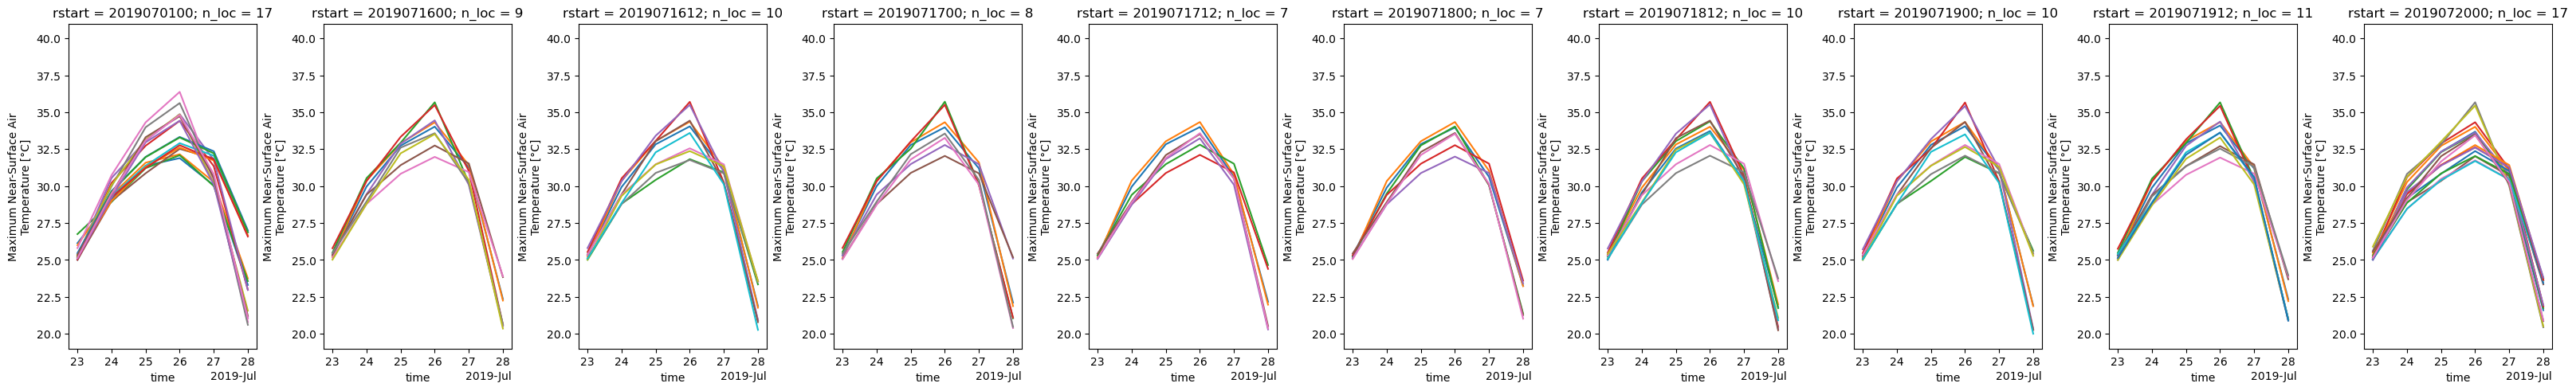

In [7]:
ncols = len(run_info_list)
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols * 3.2, 4.8), layout="constrained")

for idx in range(len(run_info_list)):
    rstart, _ = run_info_list[idx]
    ax = axs[idx]

    tasmax = ds.tasmax.sel(rstart=rstart).dropna(dim="time")
    heatwave_mask_1 = tasmax.rolling(time=5).construct("window_dim").min("window_dim", skipna=False) >= 25
    heatwave_mask_2 = tasmax.rolling(time=3).construct("window_dim").min("window_dim", skipna=False) >= 30
    heatwave_mask = (heatwave_mask_1 & heatwave_mask_2).any("time")
    tasmax_masked = tasmax.where(heatwave_mask)

    tasmax_heatwave_locs = tasmax_masked.stack(loc=["lat", "lon"]).dropna("loc").load().reset_index("loc")
    tasmax_heatwave_locs.plot(ax=ax, x="time", hue="loc")
    ax.set_title(f"rstart = {rstart}; n_loc = {len(tasmax_heatwave_locs['loc'])}")
    ax.legend("").remove()
    ax.set_ylim(19, 41)

plt.show()